---
## ***DATA ANALYSIS ON BAIL PREDICTON DATASET***
---

##### ***Neccessary Imports***

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.font_manager as fm
from googletrans import Translator
from wordcloud import WordCloud

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
sns.set(style='whitegrid')

In [15]:
file_path = r"U:\LegalAnalytics\BailPrediction\data\preprocessed\full_data_train.json"

In [16]:
with open(file_path, 'r', encoding='utf-8') as file:
    test_data = json.load(file)

---
#### ***Converting to Pandas DataFrame***
---

In [17]:
df = pd.DataFrame([{
    'id': entry['id'],
    'district': entry['district'],
    'facts_and_arguments': ' '.join(entry['text'].get('facts-and-arguments', [])),
    'judge_opinion': ' '.join(entry['text'].get('judge-opinion', [])),
    'label': entry['label']
} for entry in test_data])

---
#### ***Taking Sample (Stratified Random Sampling)***
---

In [18]:
sample_df = pd.concat([
    pd.concat([
        df[(df['district'] == district) & (df['label'] == 0)].sample(
            n=min(50, len(df[(df['district'] == district) & (df['label'] == 0)])), 
            random_state=42
        ),
        df[(df['district'] == district) & (df['label'] == 1)].sample(
            n=min(50, len(df[(df['district'] == district) & (df['label'] == 1)])), 
            random_state=42
        )
    ])
    for district in df['district'].unique()
], ignore_index=True)

In [19]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7069 entries, 0 to 7068
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   7069 non-null   object
 1   district             7069 non-null   object
 2   facts_and_arguments  7069 non-null   object
 3   judge_opinion        7069 non-null   object
 4   label                7069 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 276.3+ KB


---
#### ***Recording the District Names***
---

In [20]:
for i, district in enumerate(list(df['district'].unique())):
    print(f"{i+1}) {district}")

1) kanshiramnagar
2) siddharthnagar
3) sitapur
4) gorakhpur
5) moradabad
6) muzaffarnagar
7) bijnor
8) kheri
9) maharajganj
10) varanasi
11) etawah
12) agra
13) sant_kabir_nagar
14) sonbhadra
15) jaunpur
16) chitrakoot
17) sultanpur
18) ambedkar_nagar
19) kanpur_nagar
20) bagpat
21) bahraich
22) meerut
23) gonda
24) pilibhit
25) hardoi
26) farrukhabad
27) shravasti
28) kannauj
29) bareilly
30) saharanpur
31) kanpur_dehat
32) budaun
33) shahjahanpur
34) rampur
35) mirzapur
36) jalaun
37) mathura
38) lalitpur
39) mainpuri
40) lucknow
41) azamgarh
42) firozabad
43) fatehpur
44) ghaziabad
45) balrampur
46) auraiya
47) raebareli
48) gautam_buddha_nagar
49) etah
50) kushinagar
51) mahoba
52) banda
53) unnao
54) kaushambi
55) faizabad
56) hamirpur_up
57) bulandshahar
58) mau
59) ghazipur
60) pratapgarhdistrict
61) bhadohi
62) hapur
63) barabanki
64) hathras
65) allahabad
66) ballia
67) jyotiba_phule_nagar
68) basti
69) aligarh
70) deoria
71) jhansi


In [21]:
sample_df['facts_and_arguments_length'] = sample_df['facts_and_arguments'].apply(len)
sample_df['judge_opinion_length'] = sample_df['judge_opinion'].apply(len)

In [22]:
sample_df.head(1)

,id,district,facts_and_arguments,judge_opinion,label,facts_and_arguments_length,judge_opinion_length
0,Bail Application_1069_201916-08-2019178,kanshiramnagar,प्रस्तुत जमानत प्रार्थना पत्र अभियुक्त टिकू पु...,"उभय पक्ष के तकौँ <नाम> विचार किया गया, उपलब्ध ...",0,2995,926


---
#### ***Counts of Categories***
---

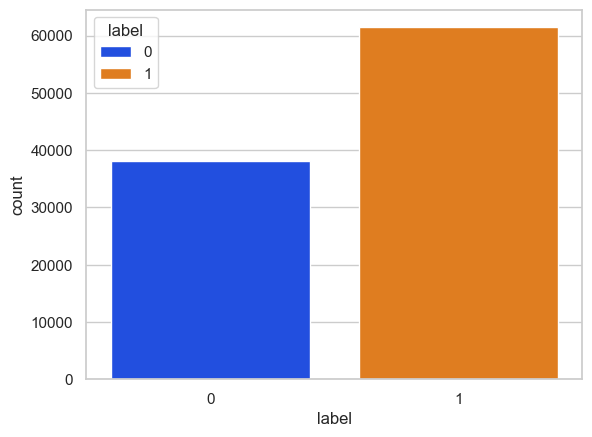

In [23]:
sns.countplot(x = 'label', hue = 'label', data = df, palette="bright")
plt.show()

---
### ***Handling Outliers***
---

In [24]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [25]:
sample_df = remove_outliers_iqr(sample_df, 'facts_and_arguments_length')
sample_df = remove_outliers_iqr(sample_df, 'judge_opinion_length')

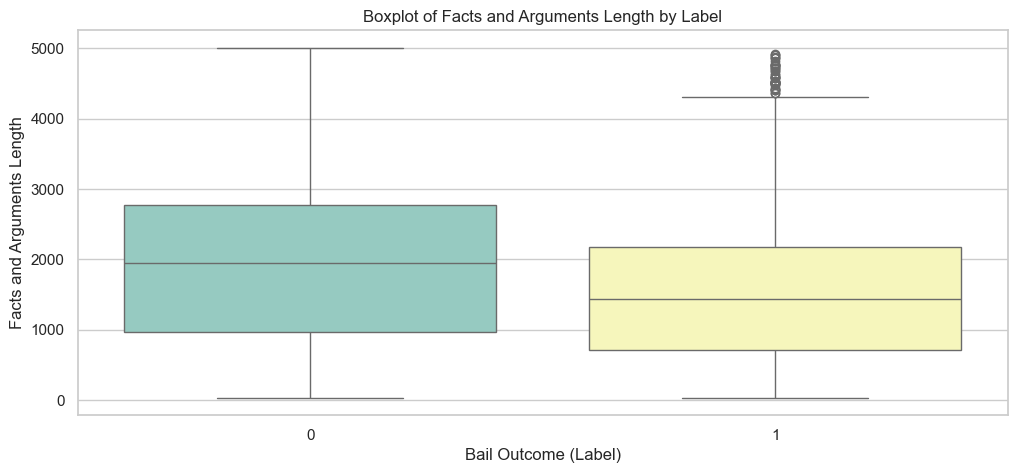

In [26]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='label', y='facts_and_arguments_length', data=sample_df, palette='Set3')
plt.title('Boxplot of Facts and Arguments Length by Label')
plt.xlabel('Bail Outcome (Label)')
plt.ylabel('Facts and Arguments Length')
plt.show()

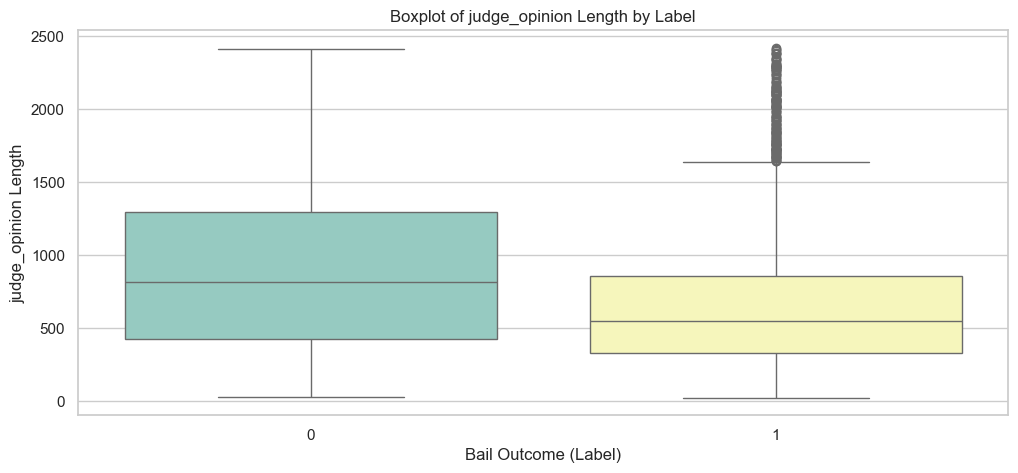

In [27]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='label', y='judge_opinion_length', data=sample_df, palette='Set3')
plt.title('Boxplot of judge_opinion Length by Label')
plt.xlabel('Bail Outcome (Label)')
plt.ylabel('judge_opinion Length')

plt.show()

---
### ***Ananlysing Frequency Distributions***
---

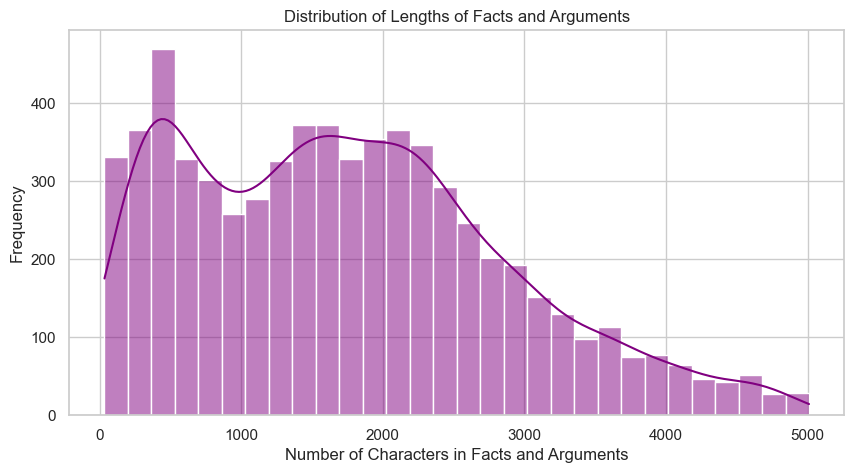

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(sample_df['facts_and_arguments_length'], bins=30, kde=True, color='purple')
plt.title('Distribution of Lengths of Facts and Arguments')
plt.xlabel('Number of Characters in Facts and Arguments')
plt.ylabel('Frequency')
plt.show()

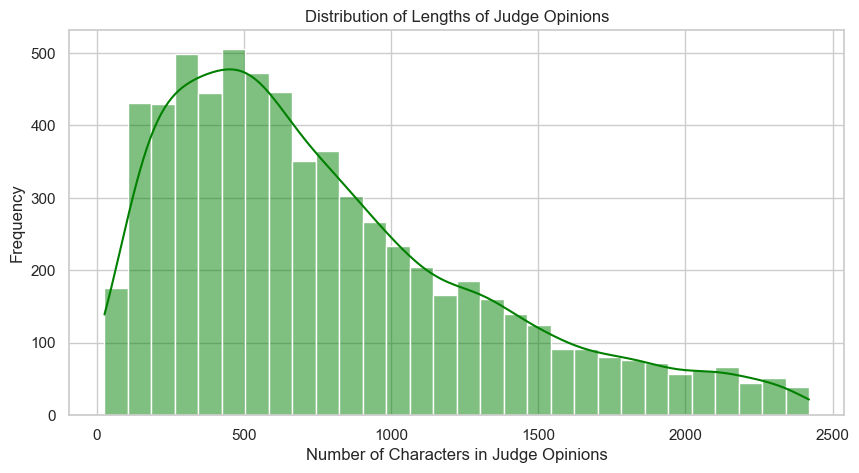

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(sample_df['judge_opinion_length'], bins=30, kde=True, color='green')
plt.title('Distribution of Lengths of Judge Opinions')
plt.xlabel('Number of Characters in Judge Opinions')
plt.ylabel('Frequency')
plt.show()

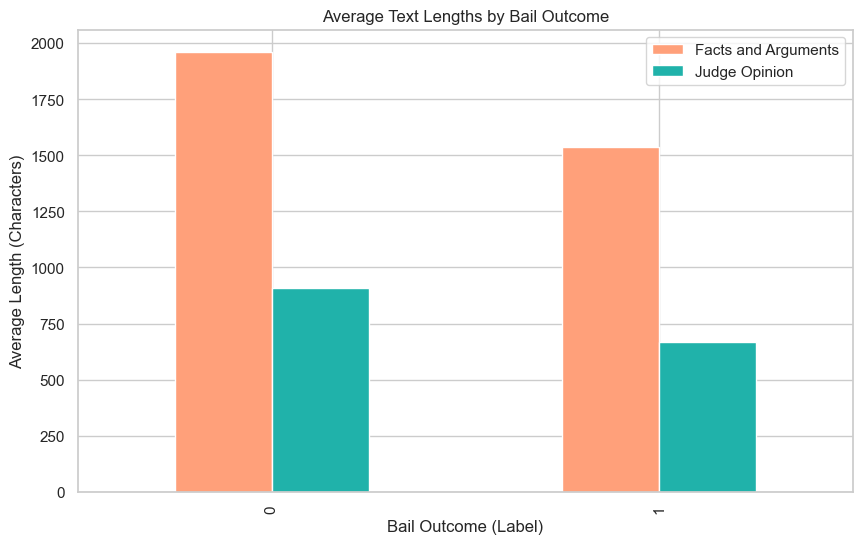

In [30]:
avg_lengths = sample_df.groupby('label')[['facts_and_arguments_length', 'judge_opinion_length']].mean()
avg_lengths.plot(kind='bar', figsize=(10, 6), color=['#FFA07A', '#20B2AA'])
plt.title('Average Text Lengths by Bail Outcome')
plt.xlabel('Bail Outcome (Label)')
plt.ylabel('Average Length (Characters)')
plt.legend(['Facts and Arguments', 'Judge Opinion'])
plt.show()

---
### ***Tansformation ~ Normalization***
---

In [31]:
sample_df['facts_and_arguments_boxcox'], _ = boxcox(sample_df['facts_and_arguments_length'] + 1)  # Adding 1 to avoid zero values
sample_df['judge_opinion_boxcox'], _ = boxcox(sample_df['judge_opinion_length'] + 1)

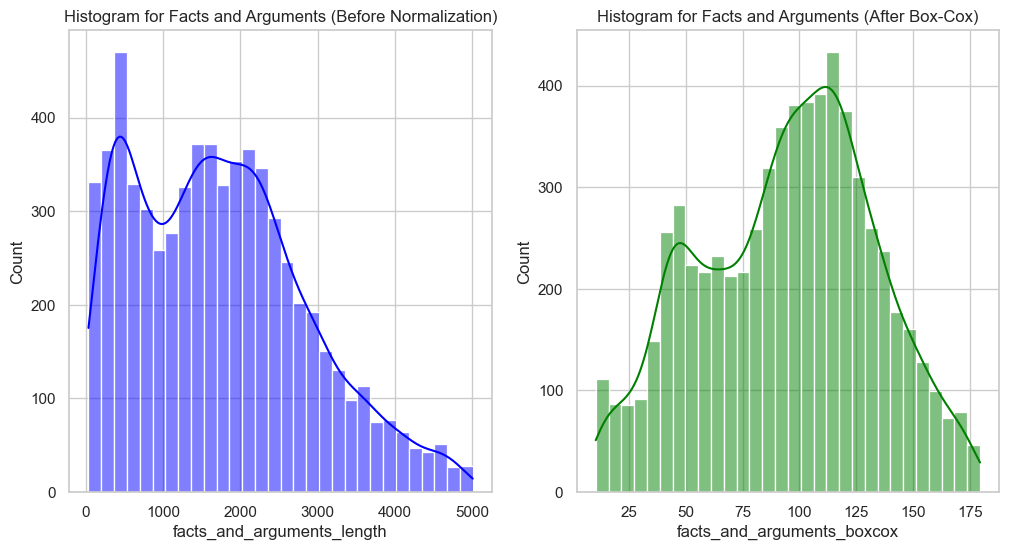

In [32]:
plt.figure(figsize=(12, 6))

# Plot histogram for 'facts_and_arguments_length' before Box-Cox
plt.subplot(1, 2, 1)
sns.histplot(sample_df['facts_and_arguments_length'], kde=True, color='blue', bins=30)
plt.title('Histogram for Facts and Arguments (Before Normalization)')

# Plot histogram for 'facts_and_arguments_boxcox' after Box-Cox
plt.subplot(1, 2, 2)
sns.histplot(sample_df['facts_and_arguments_boxcox'], kde=True, color='green', bins=30)
plt.title('Histogram for Facts and Arguments (After Box-Cox)')

plt.show()

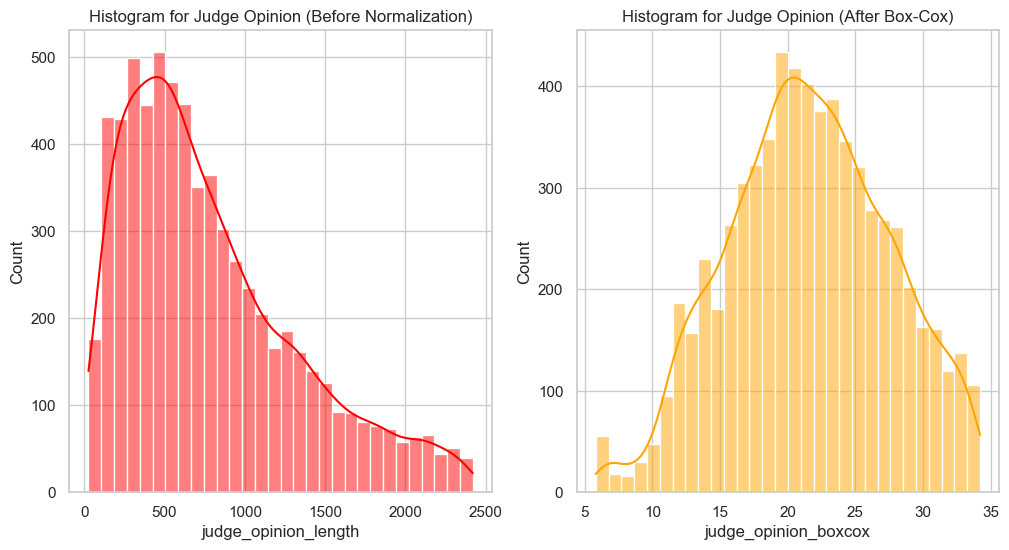

In [33]:
# After normalization (Box-Cox)
plt.figure(figsize=(12, 6))

# Plot histogram for 'judge_opinion_length' before Box-Cox
plt.subplot(1, 2, 1)
sns.histplot(sample_df['judge_opinion_length'], kde=True, color='red', bins=30)
plt.title('Histogram for Judge Opinion (Before Normalization)')

# Plot histogram for 'judge_opinion_boxcox' after Box-Cox
plt.subplot(1, 2, 2)
sns.histplot(sample_df['judge_opinion_boxcox'], kde=True, color='orange', bins=30)
plt.title('Histogram for Judge Opinion (After Box-Cox)')

plt.show()

---
### ***Statistical Test***
---

## ***t test***

## Reasons for Choosing T-Test

The independent t-test was selected for this analysis to compare the means of two independent groups (granted bail vs. denied bail) for the length of text in the bail case documents. 

This test is appropriate because:
- The goal is to determine if there is a statistically significant difference between the mean text length of two groups.
- The data approximately follows a normal distribution, or the sample size is sufficiently large for the Central Limit Theorem to apply

## Hypotheses

### 1. T-Test for Facts and Arguments Length Between Labels

- **Null Hypothesis ($H_0$):** There is no significant difference in the mean length of the facts and arguments section between cases where bail is granted and cases where it is denied.

- **Alternative Hypothesis ($H_a$):** There is a significant difference in the mean length of the facts and arguments section between cases where bail is granted and cases where it is denied.

### 2. T-Test for Judge Opinion Length Between Labels

- **Null Hypothesis ($H_0$):** There is no significant difference in the mean length of the judge’s opinion between cases where bail is granted and cases where it is denied.

- **Alternative Hypothesis ($H_a$):** There is a significant difference in the mean length of the judge’s opinion between cases where bail is granted and cases where it is denied.

---


In [34]:
label_0 = sample_df[sample_df['label'] == 0]['facts_and_arguments_boxcox']
label_1 = sample_df[sample_df['label'] == 1]['facts_and_arguments_boxcox']
t_stat, p_val = stats.ttest_ind(label_0, label_1, equal_var=False)
print(f"T-test for Facts and Arguments Length between Labels:\nT-statistic: {t_stat:.2f}, P-value: {p_val}")

T-test for Facts and Arguments Length between Labels:
T-statistic: 14.33, P-value: 6.874670288543544e-46


In [35]:
label_0_opinion = sample_df[sample_df['label'] == 0]['judge_opinion_boxcox']
label_1_opinion = sample_df[sample_df['label'] == 1]['judge_opinion_boxcox']
t_stat_op, p_val_op = stats.ttest_ind(label_0_opinion, label_1_opinion, equal_var=False)
print(f"\nT-test for Judge Opinion Length between Labels:\nT-statistic: {t_stat_op:.2f}, P-value: {p_val_op}")



T-test for Judge Opinion Length between Labels:
T-statistic: 16.89, P-value: 1.1674304613123233e-62


In [36]:
correlation, p_val_corr = stats.pearsonr(sample_df['facts_and_arguments_boxcox'], sample_df['judge_opinion_boxcox'])
print(f"\nCorrelation between Facts and Arguments Length and Judge Opinion Length:\nCorrelation Coefficient: {correlation:.2f}, P-value: {p_val_corr}")



Correlation between Facts and Arguments Length and Judge Opinion Length:
Correlation Coefficient: 0.41, P-value: 2.105614307371293e-274


---
## Inferences from the Analysis

### 1. T-Test for Facts and Arguments Length Between Labels

**Inference:** The very low p-value (< 0.05) leads to the rejection of the null hypothesis. 
This suggests that there is a significant difference in the length of the facts and arguments section between cases where bail is granted and cases where it is denied.


### 2. T-Test for Judge Opinion Length Between Labels

**Inference:** The extremely low p-value (< 0.05) leads to the rejection of the null hypothesis. This confirms that there is a significant difference in the length of the judge’s opinion between cases where bail is granted and cases where it is denied.

## Correlation Analysis
**Inference:** The correlation coefficient of 0.41 indicates a moderate positive relationship between the length of the facts and arguments section and the length of the judge’s opinion. The extremely low p-value suggests that this relationship is statistically significant.

## Overall Conclusion

#### The t-tests indicate significant differences in the length of both the facts and arguments section and the judge’s opinion between cases where bail is granted and cases where it is denied. Additionally, the correlation analysis shows a moderate positive relationship between the length of the facts and arguments section and the length of the judge’s opinion, underscoring the potential importance of document length in bail prediction analysis.
---

--- 
### ***Analysing the words***
---

In [37]:
df = sample_df

In [38]:
import stopwords
hindi_stopwords = stopwords.hindi_stopwords()

In [39]:
# Preprocessing function for Hindi text
def preprocess_text(text):
    # Split the text into words
    tokens = text.split()
    # Remove stopwords and non-Hindi characters (only alphabets)
    clean_tokens = [token for token in tokens if token.isalpha() and token not in hindi_stopwords]
    return ' '.join(clean_tokens)

# Example usage for a DataFrame
df['processed_facts_and_arguments'] = df['facts_and_arguments'].apply(preprocess_text)
df['processed_judge_opinion'] = df['judge_opinion'].apply(preprocess_text)


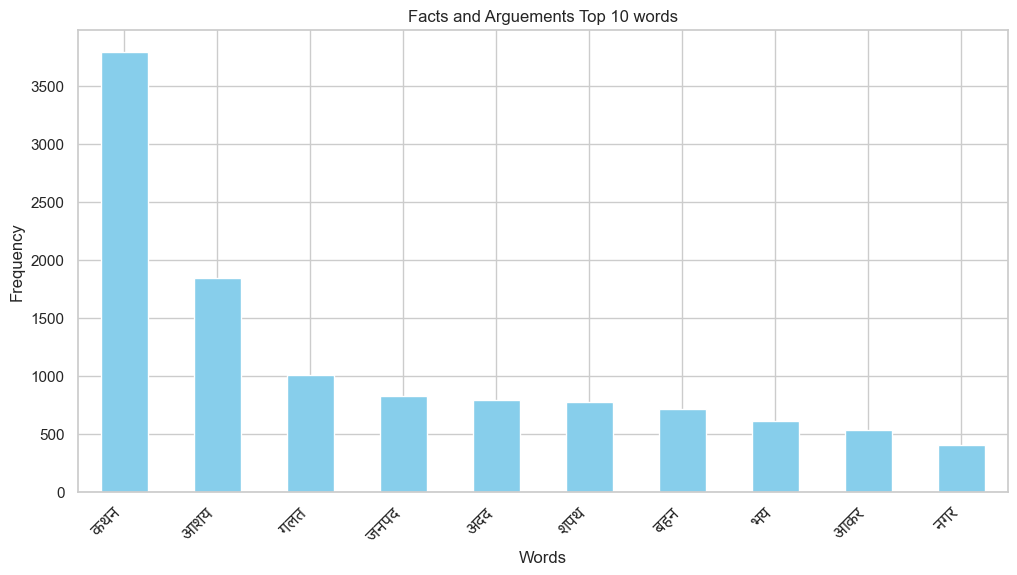

In [40]:
# CountVectorizer for the 'facts_and_arguments' column (Top 10 most common words)
cv = CountVectorizer(stop_words=hindi_stopwords, max_features=10)
word_count_matrix = cv.fit_transform(df['processed_facts_and_arguments'])
word_freq = pd.DataFrame(word_count_matrix.toarray(), columns=cv.get_feature_names_out())

# Display top words in 'facts_and_arguments'
top_words = word_freq.sum().sort_values(ascending=False)

# Set the Devanagari font path
font_path = r"C:\Fonts achu\NotoSansDevanagari-VariableFont_wdth,wght.ttf"  # Update with the actual path of the Devanagari font

# Load the font
font_prop = fm.FontProperties(fname=font_path)

# Plot with Hindi words on x-axis
top_words.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Facts and Arguements Top 10 words')
plt.xlabel('Words')
plt.ylabel('Frequency')

# Set x-axis labels to Hindi words with the specified font
plt.xticks(ticks=range(len(top_words)), labels=top_words.index, rotation=45, ha='right', fontproperties=font_prop)

# Show the plot
plt.show()


In [41]:
# Initialize the Translator
translator = Translator()

# Function to get translations
def get_translations(word):
    try:
        # Translate word to English and Tamil
        english_translation = translator.translate(word, src='hi', dest='en').text
        tamil_translation = translator.translate(word, src='hi', dest='ta').text
        return english_translation, tamil_translation
    except Exception as e:
        return 'N/A', 'N/A'

# Print top words with Tamil and English translations
print(f'{"Word":<15} | {"Frequency":<10} | {"English":<20} | {"Tamil":<20}')
print('-' * 70)

# Print top words with Tamil and English translations
for word, freq in top_words.head(10).items():
    english, tamil = get_translations(word)
    print(f'{word:<15} | {freq:<10} | {english:<20} | {tamil:<20}')

Word            | Frequency  | English              | Tamil               
----------------------------------------------------------------------
कथन             | 3798       | statement            | அறிக்கை             
आशय             | 1846       | intent               | நோக்கம்             
गलत             | 1008       | Wrong                | தவறு                
जनपद            | 829        | District             | மாவட்டம்            
अदद             | 795        | Unlike               | போலல்லாமல்          
शपथ             | 774        | Oath                 | சத்தியம்            
बहन             | 713        | Sister               | சகோதரி              
भय              | 612        | Fear                 | பயம்                
आकर             | 536        | Size                 | அளவு                
नगर             | 406        | City                 | நகரம்               


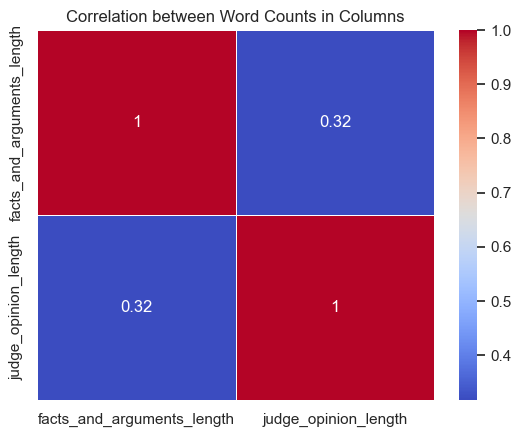

In [42]:
correlation_df = df[['facts_and_arguments_length', 'judge_opinion_length']].corr()
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Word Counts in Columns')
plt.show()

In [43]:
# Assuming your DataFrame is named df
facts_and_arguments_text = ' '.join(df['processed_facts_and_arguments'])

In [44]:
# Create wordcloud for label 0
wordcloud_ = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color="white",
    max_words=60,
    colormap="viridis",
    collocations=False,
).generate(facts_and_arguments_text)

Text(0.5, 1.0, 'Word Cloud for Facts and Arguments')

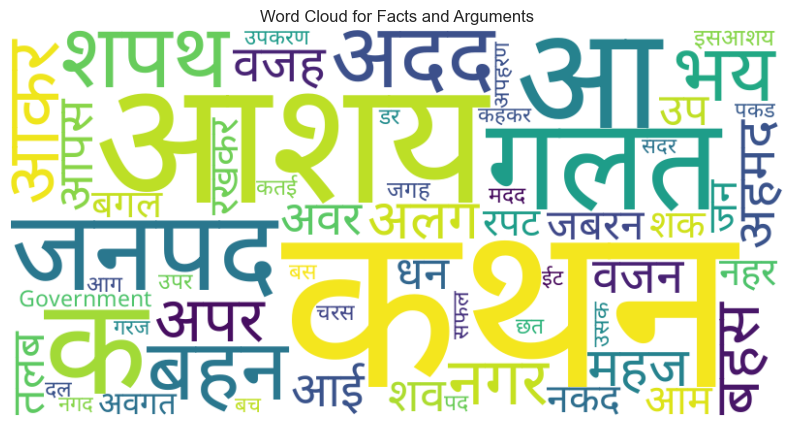

In [45]:
# Plot the wordcloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Facts and Arguments')


In [46]:
df.to_csv(r"C:\Users\ashuw\Desktop\sample_data.csv", index=False)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(text_data, n=2, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english', max_features=top_n)
    ngram_matrix = vectorizer.fit_transform(text_data.astype(str))
    ngrams = vectorizer.get_feature_names_out()
    return ngrams

# Get top bigrams from the 'processed_judge_opinion' column
top_bigrams_judge_opinion = get_top_ngrams(df['processed_judge_opinion'], n=2, top_n=10)
print("Top Bigrams in 'Processed Judge Opinion':")
print(top_bigrams_judge_opinion)


Top Bigrams in 'Processed Judge Opinion':
['अदद अदद' 'आशय कथन' 'आहत आहत' 'उभय कथन' 'कथन कथन' 'कथन गलत' 'गलत कथन'
 'गलत गलत' 'बहन बहन' 'बहस कथन']


In [48]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_sentiment(text_data):
    analyzer = SentimentIntensityAnalyzer()
    sentiments = text_data.apply(lambda x: analyzer.polarity_scores(x)['compound'])
    return sentiments

df['vader_sentiment_facts_arguments'] = vader_sentiment(df['facts_and_arguments'])
df['vader_sentiment_judge_opinion'] = vader_sentiment(df['judge_opinion'])

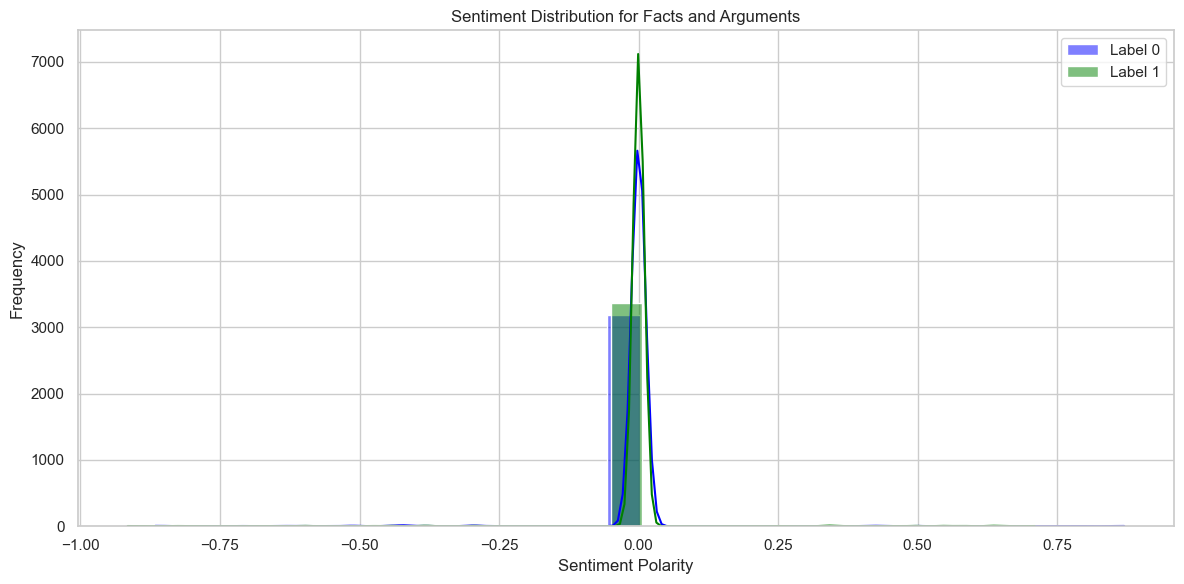

Mean Sentiment Scores by Label:
label
0   -0.002993
1    0.000103
Name: vader_sentiment_facts_arguments, dtype: float64


In [49]:
# Plot the sentiment distribution by label
plt.figure(figsize=(12, 6))

sns.histplot(df[df['label'] == 0]['vader_sentiment_facts_arguments'], bins=30, kde=True, label='Label 0', color='blue')
sns.histplot(df[df['label'] == 1]['vader_sentiment_facts_arguments'], bins=30, kde=True, label='Label 1', color='green')
plt.title('Sentiment Distribution for Facts and Arguments')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate mean sentiment scores by label
mean_sentiment_by_label = df.groupby('label')['vader_sentiment_facts_arguments'].mean()
print("Mean Sentiment Scores by Label:")
print(mean_sentiment_by_label)


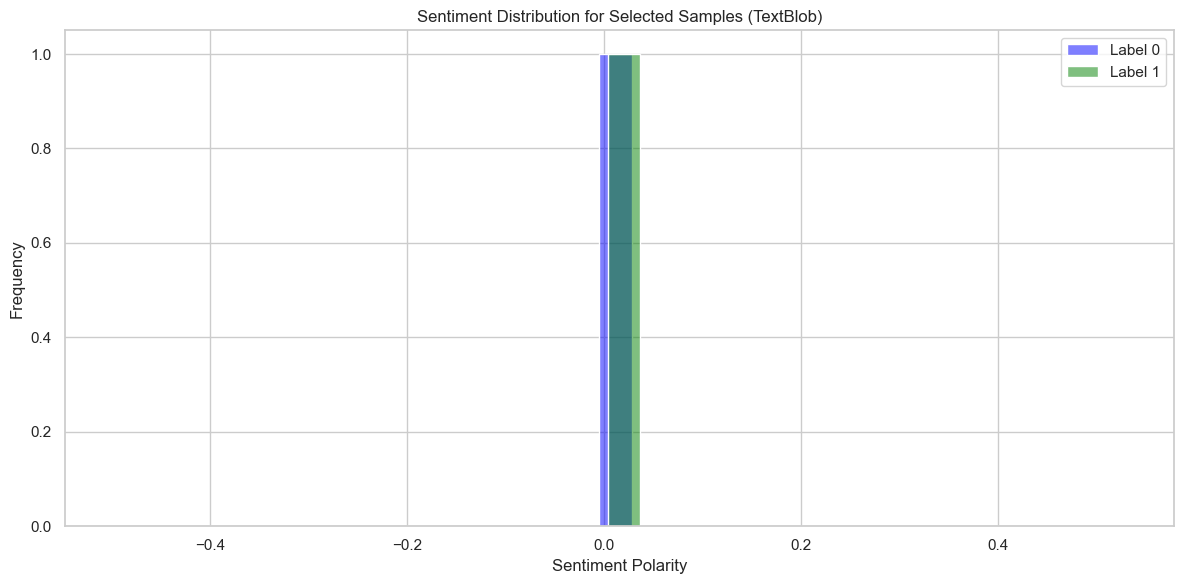

Mean Sentiment Scores by Label (TextBlob) for Selected Samples:
label
0    0.028068
1    0.003571
Name: textblob_sentiment_facts_arguments, dtype: float64


In [50]:
from textblob import TextBlob

translator = Translator()

def translate_text(text):
    translation = translator.translate(text, src='hi', dest='en')
    return translation.text

def textblob_sentiment(text_data):
    sentiments = text_data.apply(lambda x: TextBlob(translate_text(x)).sentiment.polarity)
    return sentiments

# Select samples
sample_1 = df[df['label'] == 1].iloc[0]
sample_0 = df[df['label'] == 0].iloc[0]

# Create a new DataFrame for the two selected samples
selected_df = pd.DataFrame([sample_1, sample_0])

# Calculate TextBlob sentiment for selected samples
selected_df['textblob_sentiment_facts_arguments'] = textblob_sentiment(selected_df['facts_and_arguments'])
selected_df['textblob_sentiment_judge_opinion'] = textblob_sentiment(selected_df['judge_opinion'])

# Plot the sentiment distribution for the selected samples
plt.figure(figsize=(12, 6))

sns.histplot(selected_df[selected_df['label'] == 0]['textblob_sentiment_facts_arguments'], bins=30, kde=True, label='Label 0', color='blue')
sns.histplot(selected_df[selected_df['label'] == 1]['textblob_sentiment_facts_arguments'], bins=30, kde=True, label='Label 1', color='green')
plt.title('Sentiment Distribution for Selected Samples (TextBlob)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate mean sentiment scores for selected samples
mean_sentiment_by_label = selected_df.groupby('label')['textblob_sentiment_facts_arguments'].mean()
print("Mean Sentiment Scores by Label (TextBlob) for Selected Samples:")
print(mean_sentiment_by_label)
